In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils import data
import numpy as np 
import matplotlib.pyplot as plt 
import os
import glob 
from PIL import Image

In [63]:
# 数据展示 
plt.figure(figsize=(12,8))
label_img = Image.open('./data/annotations/annotations/trimaps/Abyssinian_3.png')
label_np_img = np.array(label_img)
img = Image.open('./data/images/images/Abyssinian_3.jpg')
np_img = np.array(img)
# plt.subplot(1,2,1)
# plt.imshow(np_img)
# plt.subplot(1,2,2)
# plt.imshow(label_np_img,cmap='gray')

# print('原始图像尺寸',np_img.shape)
# print('标签图像尺寸',lab|el_np_img.shape)
# print('标签图像分类值',np.unique(label_np_img))
torch.squeeze(torch.tensor(label_np_img,dtype=torch.int64))-1 

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])

<Figure size 1200x800 with 0 Axes>

In [64]:
# 路径处理  
images = glob.glob('data/images/images/*.jpg')
annotations = [os.path.join('./data/annotations/annotations/trimaps',img_name.split('\\')[-1].replace('jpg','png')) for img_name in images]

In [65]:

# # 数据集分割
np.random.seed(42)
index = np.random.permutation(len(images))
images = np.array(images)[index]
annotations = np.array(annotations)[index]

sep = int(len(images)*0.8)
train_images = images[:sep]
train_label = annotations[:sep]

test_images = images[sep:]
test_label = annotations[sep:]

In [66]:
# 制作训练作用的数据
transform = transforms.Compose([
    transforms.Resize((256,256)), # 修改尺寸
    transforms.ToTensor()         # 张量
]) 

# 数据处理工具

class ox_dataset(data.Dataset):
    def __init__(self,img_paths,anno_paths):
        self.imgs = img_paths
        self.annos = anno_paths
    
    def __getitem__(self,index):
        img = self.imgs[index]
        anno = self.annos[index]
        # 处理原始图形
        '''
        1. 读成数组
        2. 转成 RGB 通道
        3. 转成 张量 格式
        '''
        pil_img  = Image.open(img)
        pil_img = pil_img.convert('RGB')
        img_tensor = transform(pil_img)
        
        # 处理语义分割图像
        '''
        1. 读取
        2. 重新定义为 256 * 256
        3. 张量...
        '''
        pil_anno = Image.open(anno)
        pil_anno = pil_anno.resize((256,256))
        anno_tensor = torch.tensor(np.array(pil_anno),dtype=torch.int64)
        
        return img_tensor,torch.squeeze(anno_tensor) - 1 
        
    def __len__(self):
        return len(self.imgs)



In [77]:
# 投喂数量
BATCH_SIZE = 2
# 数据 batch——size 打包
train_dataset = ox_dataset(train_images,train_label)
test_dataset = ox_dataset(test_images,test_label)

train_dl = data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dl = data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE
)

# img_batch,anno_batch = next(iter(train_dl))
# img = img_batch[0].permute(1,2,0).numpy()
# plt.subplot(1,2,1)
# plt.imshow(img)

# anno = anno_batch[0]
# plt.subplot(1,2,2)
# plt.imshow(anno)

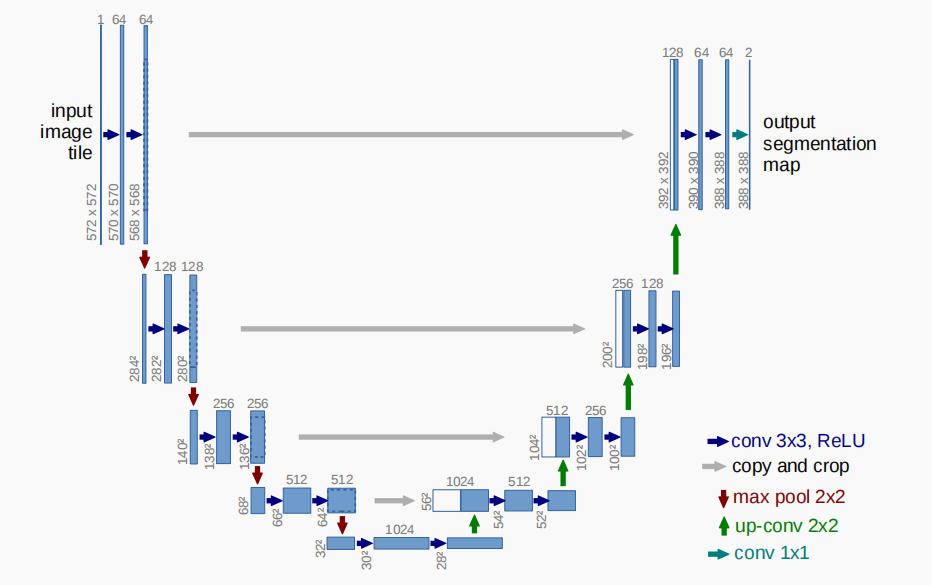

In [78]:
# 特征提取（下采样）
class Downsample(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(Downsample,self).__init__()
        self.conv_relu = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
        )
        
        self.pool = nn.MaxPool2d(kernel_size=2)
    
    def forward(self,x,is_pool=True):
        if is_pool:
            x = self.pool(x)
        x = self.conv_relu(x)
        return x
        
            

In [79]:
# 上采样 （解码，还原）
class Upsample(nn.Module):
    def __init__(self,channels):
        super(Upsample,self).__init__()
        self.conv_relu = nn.Sequential(
            nn.Conv2d(2*channels,channels,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels,channels,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
        )
        
        self.upconv_relu = nn.Sequential(
            nn.ConvTranspose2d(
                channels,
                channels//2,
                kernel_size=3,
                stride=2,
                padding=1,
                output_padding=1),
            nn.ReLU(inplace=True)
        )
    def forward(self,x):
        x = self.conv_relu(x)
        x = self.upconv_relu(x)
        return x

In [80]:
class Unet_model(nn.Module):
    def __init__(self):
        super(Unet_model,self).__init__()
        # 特征提取组件的搭建完成
        self.down1 = Downsample(3,64)
        self.down2 = Downsample(64,128)
        self.down3 = Downsample(128,256)
        self.down4 = Downsample(256,512)
        self.down5 = Downsample(512,1024)
        
        # 上采样
        self.up = nn.Sequential(
            nn.ConvTranspose2d(
                1024,
                512,
                kernel_size=3,
                stride=2,
                padding=1,
                output_padding=1),
            nn.ReLU(inplace=True)
        )
        self.up1 = Upsample(512)
        self.up2 = Upsample(256)
        self.up3 = Upsample(128)
        self.conv_2 = Downsample(128,64)
        # 输出层
        self.last = nn.Conv2d(64,3,kernel_size=1)
    
    def forward(self,x):
        x1 = self.down1(x,ix_pool=False)
        x2 = self.down1(x1)
        x3 = self.down1(x2)
        x4 = self.down1(x3)
        x5 = self.down1(x4)
        x5 = self.up(x5)
        x5 = torch.cat([x4,x5],dim=1)
        x5 = self.up1(x5)
        x5 = torch.cat([x3,x5],dim=1)
        x5 = self.up2(x5)
        x5 = torch.cat([x2,x5],dim=1)
        x5 = self.up3(x5)
        x5 = torch.cat([x1,x5],dim=1)
        x5 = self.conv_2(x5,is_pool=False)
        x5 = self.last(x5)
        
        return x5